# **Curso Python: Clase 22**
## Principal Component Analysis

# Principal Component Analysis (PCA)
This notebook performs PCA on a selected set of environmental variables and visualizes the results with a scree plot and biplot.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# Read in the data from the csv file
CO2Data = pd.read_csv("../folder_datos/Terminos_lagoon_TA_DIC_2023_RawData.csv")

In [3]:
# Select variables for PCA
selected_vars = ['depth_m', 'do_mg_l', 'sal_psu', 
                 'turbidity_fnu', 'temp_c', 'ta_micromol_kg', 
                 'dic_micromol_kg', 'chlorophy_microg_l']

# Drop missing values and scale the data
X = CO2Data[selected_vars].dropna()
X_scaled = StandardScaler().fit_transform(X)

##  Bartlett's test and KMO test for factor analysis suitability.

In [4]:
def perform_adequacy_tests(data, selected_columns):
    """
    Perform Bartlett's test and KMO test for factor analysis.

    Parameters:
        data (pd.DataFrame): The input dataset.
        selected_columns (list): List of column names to include in the analysis.

    Returns:
        dict: Results of Bartlett's test and KMO test.
    """
    from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

    # Select numeric data and drop missing values
    numeric_values = data[selected_columns].dropna().select_dtypes(include=['float64', 'int64']).values

    # Perform Bartlett's test
    chi_square, p_value = calculate_bartlett_sphericity(numeric_values)
    print(f"Bartlett's Test: p-value = {p_value:.4f}, chi-square = {chi_square:.4f}")

    # Perform KMO test
    _, kmo_model = calculate_kmo(numeric_values)
    print(f"KMO Value: {kmo_model:.1f}")

   # 📝 Print interpretation of KMO value
    if kmo_model > 0.8:
        print("✅ Suitability: Excellent 🌟")
    elif 0.7 <= kmo_model <= 0.79:
        print("✅ Suitability: Acceptable 👍")
    elif 0.6 <= kmo_model <= 0.69:
        print("⚠️ Suitability: Mediocre 🤔")
    else:
        print("❌ Suitability: Poor 🚫")

    print("ℹ️ Interpretation: A KMO value above 0.6 is considered acceptable for factor analysis.")

    # 🔄 Return results
    return {"bartlett": {"chi_square": chi_square, "p_value": p_value}, "kmo": kmo_model}

In [5]:
# Select the variables for analysis
# Note: Ensure that the column names match those in your dataset
selected_vars = ['depth_m', 'do_mg_l', 'sal_psu', 
                 'turbidity_fnu', 'temp_c', 'ta_micromol_kg', 'dic_micromol_kg', 'chlorophy_microg_l']

# Perform the adequacy tests
results = perform_adequacy_tests(CO2Data, selected_vars)

Bartlett's Test: p-value = 0.0000, chi-square = 317.8409
KMO Value: 0.5
❌ Suitability: Poor 🚫
ℹ️ Interpretation: A KMO value above 0.6 is considered acceptable for factor analysis.


## Perform PCA 

In [6]:
# Perform PCA
pca = PCA()
principal_components = pca.fit_transform(X_scaled)
explained_variance = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_

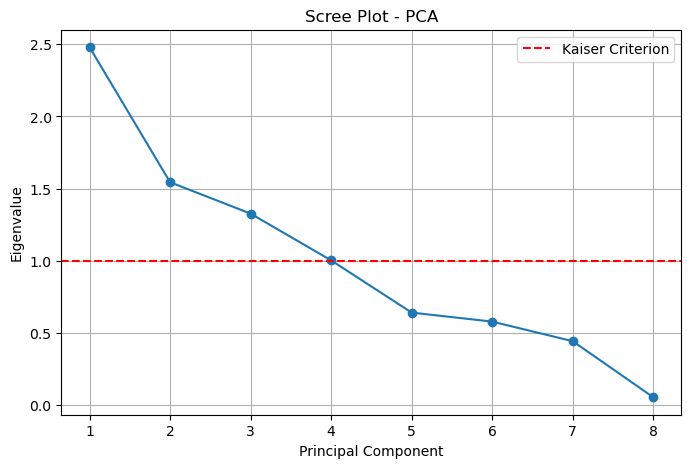

In [7]:
# Scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')
plt.axhline(y=1, color='red', linestyle='--', label='Kaiser Criterion')
plt.title('Scree Plot - PCA')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.legend()
plt.grid(True)
plt.show()

## Simple biplot PCA

In [8]:
# Biplot function
def biplot(scores, coeff, labels=None):
    xs = scores[:, 0]
    ys = scores[:, 1]
    plt.figure(figsize=(8, 6))
    plt.scatter(xs, ys, alpha=0.5)
    for i in range(coeff.shape[0]):
        plt.arrow(0, 0, coeff[i, 0]*2, coeff[i, 1]*2, 
                  color='r', alpha=0.5)
        if labels is None:
            plt.text(coeff[i, 0]*2.2, coeff[i, 1]*2.2, f"Var{i+1}", color='g')
        else:
            plt.text(coeff[i, 0]*2.2, coeff[i, 1]*2.2, labels[i], color='g')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Biplot")
    plt.grid()
    plt.show()

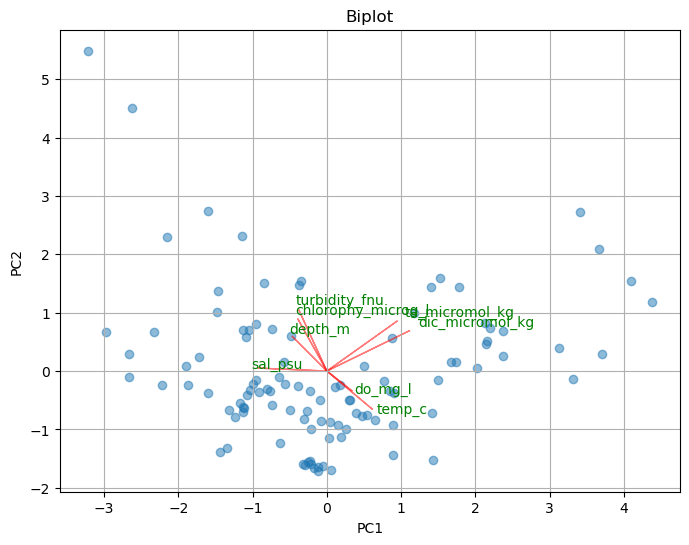

In [9]:
# Display biplot for first two principal components
biplot(principal_components, pca.components_.T, labels=selected_vars)

## Include details on PCA results plot

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.patheffects import withStroke
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from typing import Optional, List, Tuple, Union # For type hinting

def plot_pca_biplot(
    df: pd.DataFrame,
    variables: List[str],
    group_col: Optional[str] = None,
    label_col: Optional[str] = None,
    scale_arrows: float = 2.5,
    figsize: Tuple[int, int] = (10, 10),
    title: str = "PCA Biplot",
    save_path: Optional[str] = None,
    point_size: int = 60,
    point_alpha: float = 0.8,
    arrow_color: str = 'black',
    arrow_linewidth: float = 2.0,
    arrow_alpha: float = 0.85,
    text_label_fontsize: float = 6.5,
    text_label_alpha: float = 0.6,
    var_label_fontsize: int = 12,
    var_label_color: str = 'green',
) -> None:
    """
    Generates a PCA biplot visualizing principal components scores and loadings.

    Returns:
        None: Displays or saves the Matplotlib plot.
    """
    # 1. Data Preparation
    cols_to_use = variables + [col for col in [group_col, label_col] if col]
    df_filtered = df.dropna(subset=cols_to_use).copy() # Use .copy() to avoid SettingWithCopyWarning

    if df_filtered.empty:
        print("Warning: DataFrame is empty after dropping NaNs. Cannot generate plot.")
        return

    X = df_filtered[variables]
    X_scaled = StandardScaler().fit_transform(X)

    # 2. PCA Calculation
    pca = PCA(n_components=2)
    scores = pca.fit_transform(X_scaled) # PC scores for each data point
    loadings = pca.components_.T         # Loadings for each variable

    # 3. Group and Label Information
    groups = df_filtered[group_col] if group_col else None
    labels = df_filtered[label_col] if label_col else None
    unique_groups = sorted(groups.unique()) if groups is not None else [None] # Handle None case for looping
    
    # Prepare colors only if grouping is needed
    colors = {}
    if groups is not None and len(unique_groups) > 0:
       num_groups = len(unique_groups)
       cmap = colormaps.get_cmap('viridis').resampled(num_groups)
       colors = {group: cmap(i) for i, group in enumerate(unique_groups)}
    else:
        # Set a default color if no grouping or only one group (which might be None)
        default_color = 'blue' 

    # 4. Plotting
    fig, ax = plt.subplots(figsize=figsize)
    ax.axhline(0, color='lightgray', lw=1, zorder=1)
    ax.axvline(0, color='lightgray', lw=1, zorder=1)

    # Plot Scores (Data Points)
    if groups is not None:
        for group in unique_groups:
            idx = (groups == group).values
            ax.scatter(scores[idx, 0], scores[idx, 1],
                       label=str(group), # Ensure group name is string for label
                       s=point_size, alpha=point_alpha,
                       edgecolor='white', linewidth=0.6,
                       color=colors[group], zorder=2)
        ax.legend(title=group_col, fontsize=10, title_fontsize=11)
    else:
        # Plot all points with default color if no groups
        ax.scatter(scores[:, 0], scores[:, 1], s=point_size, alpha=point_alpha,
                   color=default_color, edgecolor='white', linewidth=0.6, zorder=2)

    # Plot Point Labels (if specified)
    if labels is not None:
        # Iterate using index to ensure alignment with scores
        for i, txt in enumerate(labels):
             ax.text(scores[i, 0], scores[i, 1], txt,
                     fontsize=text_label_fontsize, alpha=text_label_alpha, zorder=3)

    # Plot Loadings (Variable Arrows)
    for i, var in enumerate(variables):
        arrow_x = loadings[i, 0] * scale_arrows
        arrow_y = loadings[i, 1] * scale_arrows
        ax.arrow(0, 0, arrow_x, arrow_y,
                 color=arrow_color, linewidth=arrow_linewidth, alpha=arrow_alpha,
                 head_width=0.1, head_length=0.12, length_includes_head=True, zorder=4)
        ax.text(arrow_x * 1.1, arrow_y * 1.1, var,
                fontsize=var_label_fontsize, ha='center', va='center', color=var_label_color,
                path_effects=[withStroke(linewidth=3, foreground='white')], zorder=5)

    # 5. Plot Customization & Finalization
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=14, weight='bold')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=14, weight='bold')
    ax.set_title(title, fontsize=16, weight='bold')
    ax.set_aspect('equal') # Ensure aspect ratio is equal for PCA interpretability

    # Set reasonable limits based on scores, adding a margin
    margin_factor = 0.1 # Percentage margin
    xlim_min, xlim_max = scores[:, 0].min(), scores[:, 0].max()
    ylim_min, ylim_max = scores[:, 1].min(), scores[:, 1].max()
    x_margin = (xlim_max - xlim_min) * margin_factor
    y_margin = (ylim_max - ylim_min) * margin_factor
    ax.set_xlim(xlim_min - x_margin, xlim_max + x_margin)
    ax.set_ylim(ylim_min - y_margin, ylim_max + y_margin)

    plt.tight_layout()

    # 6. Save or Show
    if save_path:
        # Determine DPI based on file extension for common raster formats
        is_raster = save_path.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff'))
        dpi = 600 if is_raster else None # Use 300 dpi for raster, None for vector (svg, pdf)
        try:
            plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
            print(f"Plot saved to {save_path}")
        except Exception as e:
            print(f"Error saving plot: {e}")
    
    plt.show()


Plot saved to ../output_files/pca_biplot_terminos_lagoon.pdf


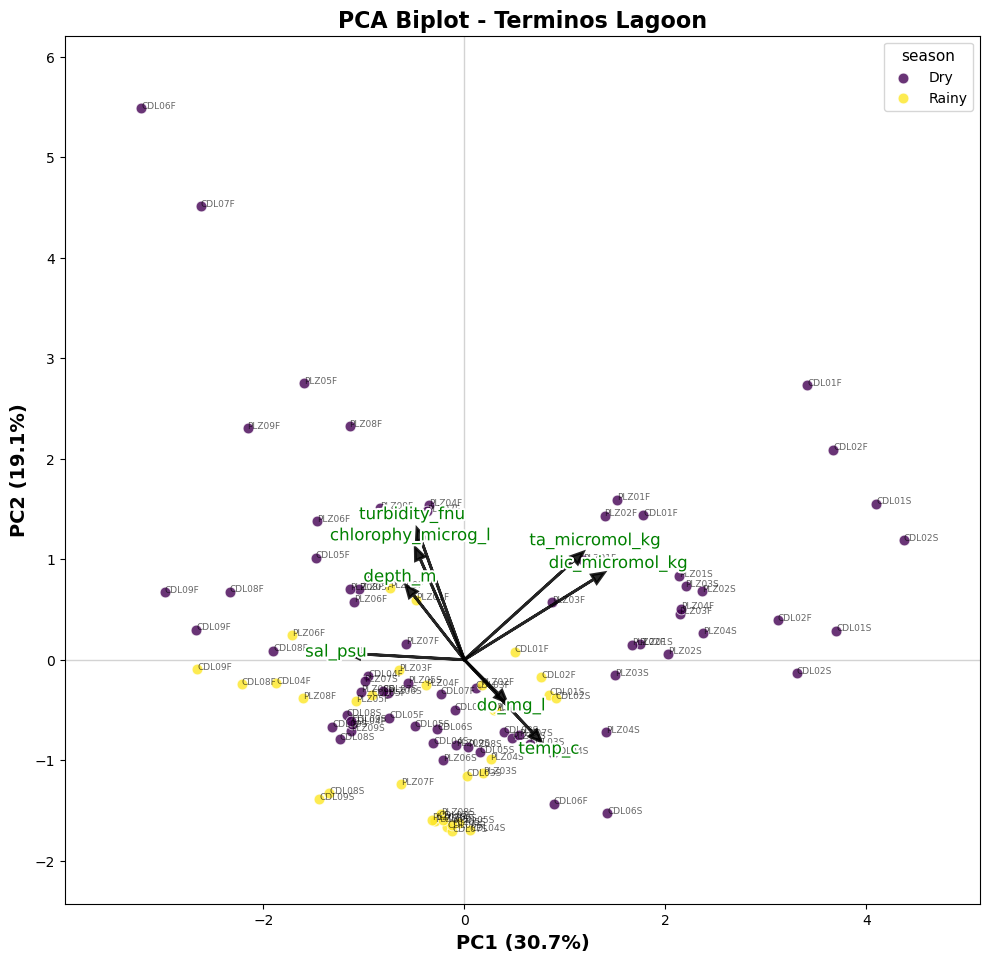

In [11]:
# Ejemplo de uso con los datos cargados
plot_pca_biplot(
    df=CO2Data,
    variables=selected_vars,
    group_col='season',
    label_col='sample',
    title='PCA Biplot - Terminos Lagoon',
    save_path='../output_files/pca_biplot_terminos_lagoon.pdf',
)